## 5.2 Training a convnet from scratch on a small dataset

We will focus on classifying images as dogs or cats in a dataset containing 4000 pictures of cats and dogs (2000 cats, 2000 dogs). We use 1000 images for training-1000 for validation, and 1000 for testing.

### 5.2.2 Downloading the data
The Dogs vs Cats. dataset isn't packaged with Keras. Instead it has been made available on Kaggle as part of a computer-vision competiution in late 2013, back when convnets weren't mainstream. The competition was won by entrants who used convnets, with best entries achieveing up to 95% accuracy.

Code below creates folders.

In [1]:
import os, shutil

# Path to the directory where the original dataset was uncompressed
original_dataset_dir = 'C:/Users/peter/Kaggle/dogs-vs-cats/data/'

# Directory where we store the smaller dataset
base_dir = 'C:/Users/peter/Kaggle/dogs-vs-cats/data/small'

# Directories for the training,validations and test splits
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')


# Directory with training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
# Directory with training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
# Directory with validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
# Directory with validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
# Directory with test cat pictures
test_cats_dir = os.path.join(test_dir, 'cats')
# Directory with test dog pictures
test_dogs_dir = os.path.join(test_dir, 'dogs')


# Make directories if nonexistant
for _dir in [base_dir, train_dir, validation_dir, test_dir, train_cats_dir,
             train_dogs_dir, validation_cats_dir, validation_dogs_dir, test_cats_dir, test_dogs_dir]:
    if not os.path.isdir(_dir):
        os.mkdir(_dir)
        print(_dir, "created")

In [32]:
# Copies the first 1000 images to train directory
# Copies the next 500 images to validation directory
# Copies the next 500 images to test directory

fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/peter/Kaggle/dogs-vs-cats/data/cat.0.jpg'

Confirm number of pictures in train, validation and test split

In [2]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500


## Building Keras CNN
Because we are attacking a binary-classification problem, we end the network with a single unit (a Dense layer of size 1) and a *sigmoid* activation. This unit will encode the probability that the network is looking at one class or the other.

In [3]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Using TensorFlow backend.


For the compilation step we use the *RMSProp* optimizer as usual. The network ended with a single sigmoid unit so the binary crossentropy is used as the loss.

For more information on the RMS optimizer visit: https://www.coursera.org/lecture/deep-neural-network/rmsprop-BhJlm

In [5]:
from keras import optimizers
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

### 5.2.4 Data preprocessing
The data should be formatted into appropriately preprocessed floating-point tensors before being fed into the network

1. Read the picture files.
2. Decode the JPEG content to RGB grid of pixels.
3. Convert these into floating-point tensors.
4. Rescale the pixel values (between 0 and 255) to the [0, 1] interval (neural networks prefer to deal with small input values)

Keras has a module with image-preprocessing helper tools located at `keras.preprocessing.image`. In particular it contains the class `ImageDataGenerator` which lets you quickly set up Python geenerators that can automatically turn image files on disk into batches of preprocessed tensors.

In [5]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255) #Generator of the images. Augmentation would enter more arguments here
test_datagen = ImageDataGenerator(rescale=1./255) #Augmentation cannot be done with test data!

train_generator = train_datagen.flow_from_directory(train_dir, # target directory
                                                    target_size=(150, 150), # resize all images to 150 x 150
                                                    batch_size=20,
                                                    class_mode='binary') # binary labels

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(150, 150),
                                                        batch_size=20,
                                                        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Checking output of generators. It yields batches of 150x150 RGB images (shape (20,150,150,3)) and binary labels (shape (20,)). There are 20 samples in each batch (the batch size). The generator yields these batches indefinitely: it loops endlessly over the images in the target folder. For this reason we need to `break` the iteration loop at some point.

In [6]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


We fit the data to the model using the `fit_generator` method: the equivalent of `fit` for data generators like this one. The first input expects a Python generator that yields batches of inputs and targets endlessly. The Keras model needs to know how many samples to draw from the generator before declaring and epoch over. This is the role of the `steps_per_epoch` argument. After having run for `steps_per_epoch` gradient descent steps-the fitting process will move to the next epoch.

When using `fit_generator`, you can pass a `validation _data` argument much as the `fit` method. If you pass a generator as a `validation_data`, then the generator is expected to yield batches of validation data endlessly; thus you should also specify the `validation_steps` argument, which tells the process how many batches from the validation generator for evaluation.

In [44]:
# Fitting the model using a batch generator
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/5
100/100 [==============================] - 141s 1s/step - loss: 0.6827 - acc: 0.5515 - val_loss: 0.7207 - val_acc: 0.5110
Epoch 2/5
100/100 [==============================] - 149s 1s/step - loss: 0.6392 - acc: 0.6275 - val_loss: 0.6194 - val_acc: 0.6620
Epoch 3/5
100/100 [==============================] - 164s 2s/step - loss: 0.5938 - acc: 0.6865 - val_loss: 0.6008 - val_acc: 0.6700
Epoch 4/5
100/100 [==============================] - 170s 2s/step - loss: 0.5555 - acc: 0.7115 - val_loss: 0.6348 - val_acc: 0.6350
Epoch 5/5
100/100 [==============================] - 165s 2s/step - loss: 0.5382 - acc: 0.7310 - val_loss: 0.5966 - val_acc: 0.6810


It's always good practice to save your model after training.

In [46]:
model.save('cats_and_dogs_small_1.h5')
model = models.load_model('C:/Users/peter/Kaggle/dogs-vs-cats/cats_and_dogs_small_2.h5')

Save the callback `History` object.

We can plot the loss and accuracy of the model over the training and validation data during training.

In [15]:
# import pickle
# history = pickle.load(open('C:/Users/peter/Kaggle/dogs-vs-cats/trainHistoryDict', 'rb'))

In [10]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

NameError: name 'history' is not defined

The plots are characteristic of overfitting. The training accuracy increases linearly over time until it reaches nearly 100%, whereas the validation accuracy stalls at 70-72%. Because we have relatively few traiing samples (2000), overfitting will be the primary concern. There are some techniques that mitigate overfitting, such as dropout and weight decay (L2 regularization). We will work with a new one specific to computer vision and used almost universally when processing images with deep-learning models: *data augmentation*.

### 5.2.5 Using data augmentation
Overfitting is caused by having too few samples to learn from, rendering you unable to train a model that can generalize to new data. Given infinite data the model would be exposed to every possible aspect of the data distribution at hand: you would never overfit.

Data augmentation takes the apporach of generating more training data from existing samples by *augmenting* the samples via a number of random transformations that yield believeable-looking images. In Keras this can be done by configuring a number of random transofmrations to be performed on the images read by the `ImageDataGenerator` instance.

In [7]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

* `rotation_range` is a value in degrees (0-180), a range within which to randomly rotate pictures.
* `width_shift` and `height_shift` are ranges (as a fraction of total width or height) within which to randomly translate pictures horizontally or vertically.
* `shear range` is for randomly appling shearing transformations.
* `zoom_range` is for randomly zooming inside pictures.
* `horizontal_flip` is for randomly flipping half of the images horizontally-relevant when there are assumptions of horizontal asymmetry.
* `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

In [22]:
from keras.preprocessing import image

# list all images in train_cats_dir
fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]
# load up third image in train_cats_dir: image 100
img_path = fnames[3]

# loads an image object with target_size
img = image.load_img(img_path, target_size=(150,150))

# Converts image into array of RGB numbers
x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)

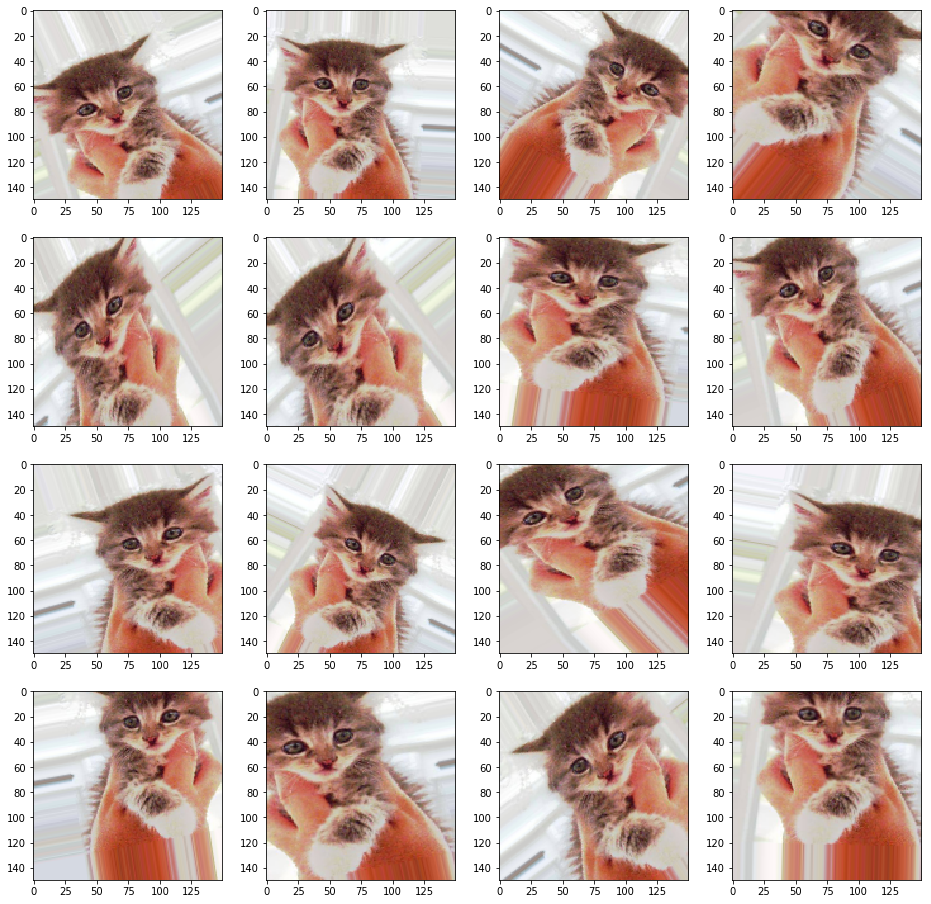

In [23]:
fig, axes = plt.subplots(figsize=(16,16), nrows=4, ncols=4)
for row in range(4):
    for col in range(4):
        axes[row,col].imshow(image.array_to_img(datagen.flow(x).__next__()[0]))

If you train a new network using this data-augmentation configuration, the network will never see the same input twice. But the inputs it sees are still heavily inter-correlated, because they come from a small number of original images-you can't produce new information, you can only remix existing information.

As such this may not be enough to completely get rid of overfitting. To further fight overfitting, you'll also add a `Dropout` layer to your model, right before the densely connected classifier.

### Defining a new convnet that includes dropout

In [22]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5)) # dropout layer is an addition to the sequential model
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [205]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=50)

model.save('cats_and_dogs_small_2.h5')
model = models.load_model('C:/Users/peter/Kaggle/dogs-vs-cats/cats_and_dogs_small_2.h5')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/5
100/100 [==============================] - 210s 2s/step - loss: 0.6923 - acc: 0.5169 - val_loss: 0.6964 - val_acc: 0.5063
Epoch 2/5
100/100 [==============================] - 226s 2s/step - loss: 0.6758 - acc: 0.5731 - val_loss: 0.6863 - val_acc: 0.5431
Epoch 3/5
100/100 [==============================] - 239s 2s/step - loss: 0.6603 - acc: 0.6072 - val_loss: 0.6419 - val_acc: 0.6148
Epoch 4/5
100/100 [==============================] - 236s 2s/step - loss: 0.6474 - acc: 0.6225 - val_loss: 0.6336 - val_acc: 0.6390
Epoch 5/5
100/100 [==============================] - 248s 2s/step - loss: 0.6300 - acc: 0.6284 - val_loss: 0.6138 - val_acc: 0.6612


In [24]:
import pickle
with open('C:/Users/peter/Kaggle/dogs-vs-cats/trainHistoryDict2', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

unpickle = pickle.load(open('C:/Users/peter/Kaggle/dogs-vs-cats/trainHistoryDict2', 'rb'))

AttributeError: 'dict' object has no attribute 'history'

In [25]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

AttributeError: 'dict' object has no attribute 'history'

# 5.3 Using a pretrained convnet
A common and highly effective approach to deep learning on small image datasets is to use a pretrained network. A *pretrained network* is a saved netwrok that was previously trained on a large dataset, typically on a large-scale image-classification task. There are two ways to use a pretrained network: *feature extraction* and *fine-tuning*.

### 5.3.1 Feature extraction
Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

In [26]:
from keras.applications import VGG16
conv_base = VGG16(weights = 'imagenet',
                 include_top=False,
                 input_shape=(150,150,3))

You pass three arguments to the constructor:
* `weights` specifies the weight checkpoint from which to initialize the model.
* `include_top` refers to including (or not) the densely connected classifier corresponds to the 1000 classes from ImageNet.
* `input_shape` is the shape of the image tensors that you'll feed to the network. This argument is purely optional.

In [228]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

The final feature map has shape (4, 4, 512). This is the feature on top of which we'll stick a densely connected classifier. At this point there are two ways to proceed:
* Running the convolutional base over your dataset, recording its output to a Numpy array on disk, and then using this data as input to a standalone, densely connected classifier similar to those in part 1. This solutions is fast and cheap to run, because it only requires running the concolutional base once for every input image, and the convolutional base is by far the most expensive part of the pipeline. But for the same reason, this technique won't allow you to use data augmentation.
* Extending the model you have (`conv_base`) by adding `Dense` layers on top, and running the whole thing end to end on the input data. This allows the use of data augmentation, because every input image goes through the convolutional base every time it's seen by the model. But for the same reason, this technique is far more expensive than the first.

# page 147

In [115]:
img_path = 'C:/Users/peter/Kaggle/dogs-vs-cats/data/small/test/cats/cat.1700.jpg'

from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

print(img_tensor.shape)

(1, 150, 150, 3)


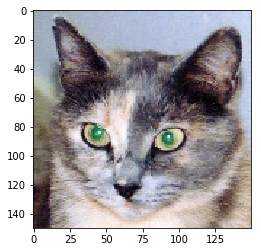

In [120]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

In [121]:
from keras import models
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input, outputs = layer_outputs)
activations = activation_model.predict(img_tensor)

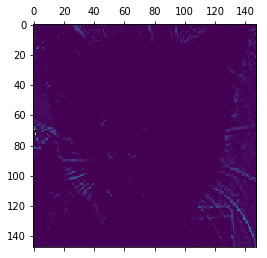

In [123]:
import matplotlib.pyplot as plt
plt.matshow(first_layer_activation[0,:,:,7], cmap='viridis')

C:\Users\peter\Miniconda3\envs\main\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


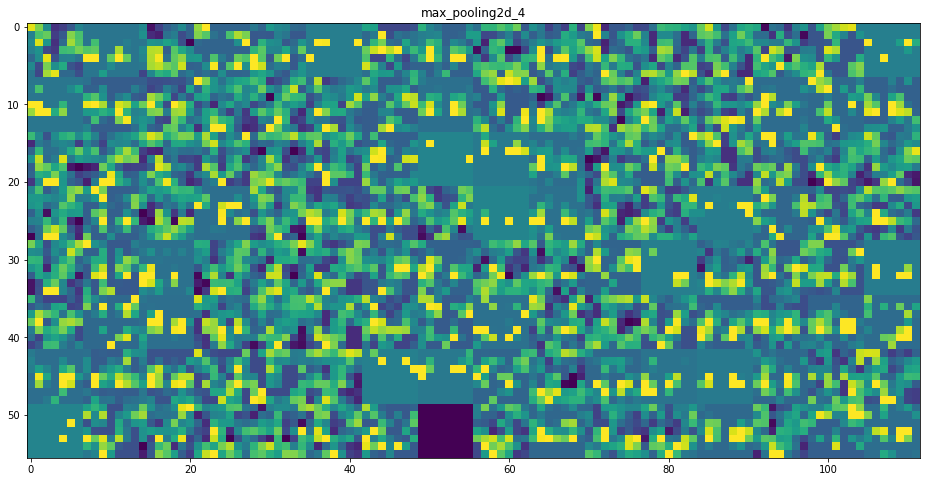

In [124]:
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    
    size = layer_activation.shape[1]
    
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

scale = 1. / size
plt.figure(figsize=(scale * display_grid.shape[1],
                    scale * display_grid.shape[0]))
plt.title(layer_name)
plt.grid(False)
plt.imshow(display_grid, aspect='auto', cmap='viridis')